# Preprocessing

Fake news in today's life is very much common, one joke or misunderstanding of the text can cause great problems for people and the government. In the era of social media, where everyone is always in touch and where information can travel instantly it won't be wrong to say that we are more prone to fake information than ever before.

Here is my basic attempt to create a fake news detector using simple technique with main attempt to deploy it and learn batch training.

In [1]:
#importing libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve
from sklearn.metrics import average_precision_score,accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import GridSearchCV

In [2]:
#reading data
data_loc = 'fake-news-data/train.csv'
News = pd.read_csv(data_loc)

In [3]:
print('The shape of the dataset is {} \n'.format(News.shape))
News.head()

The shape of the dataset is (20800, 5) 



,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
#creating a copy of the dataset with only two columns
news_copy = News[['title','text']]

#extracting labels
labels = News[['label']]
news_copy.head()

,title,text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ..."
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...


In [5]:
#checking null values in label
labels.isnull().sum()

label    0
dtype: int64

In [6]:
#checking null values in the training dataset
news_copy.isnull().sum()

title    558
text      39
dtype: int64

In [7]:
# making a loop to replace the text data with the headline if the text/news is not present
# then checking the null values in the text column

for i in range(0,news_copy.shape[0]-1):
    if(news_copy.text.isnull()[i]):
        news_copy.text[i] = news_copy.title[i]
        
news_copy.isnull().sum()

C:\Users\ysanj\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


title    558
text       0
dtype: int64

In [8]:
#Splitting data
x_train, x_test, y_train, y_test = train_test_split(news_copy, labels, test_size = 0.2, random_state = 42)

In [9]:
print('x_train:{}'.format(x_train.shape))
print('y_train:{}'.format(y_train.shape))
print('x_test:{}'.format(x_test.shape))
print('y_test:{}'.format(y_test.shape))

x_train:(16640, 2)
y_train:(16640, 1)
x_test:(4160, 2)
y_test:(4160, 1)


### with the text feature taken together

In [10]:
x_train_text = x_train['text'].copy()
x_test_text = x_test['text'].copy()

In [11]:
#vectoring using Tfidvectorizer with stop words english
tfid = TfidfVectorizer(stop_words='english',max_features=2000,max_df=0.7)

#fit and transform
tf_train = tfid.fit_transform(x_train_text)
tf_test = tfid.transform(x_test_text)

print('tf_train shape is {} tf_test shape is {}'.format(tf_train.shape,tf_test.shape))
print('y_train shape is {} y_test shape is {}'.format(y_train.shape,y_test.shape))

tf_train shape is (16640, 2000) tf_test shape is (4160, 2000)
y_train shape is (16640, 1) y_test shape is (4160, 1)


## Accuracy before thresholding

In [12]:
# using Passive Agressive Classifier
classifer = PassiveAggressiveClassifier(max_iter=50)

# fitting data to the classifier
classifer.fit(tf_train,y_train)

# predicting the test data 
y_pred = classifer.predict(tf_test)

score = accuracy_score(y_test,y_pred)
print('Accuracy before thresholding is : {}'.format(round(score*100,2)))

C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy before thresholding is : 92.69


In [13]:
#x_train_text = pd.DataFrame(x_train_text)
#x_train_text['text'] = x_train_text['text'].str.lower()

In [14]:
#Build confusion matrix
confusion_matrix(y_test,y_pred, labels=[1,0])

array([[1872,  156],
       [ 148, 1984]], dtype=int64)

## Plotting PR curve and obtaining threshold

In [15]:
# getting precision, recall and threshold values from the curve and then plotting them
prec, rec, tre = precision_recall_curve(y_test, y_pred)

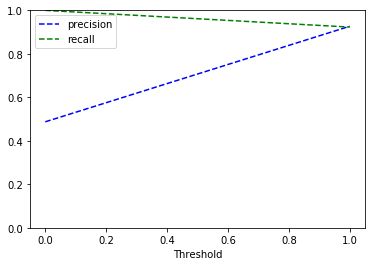

In [16]:
def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

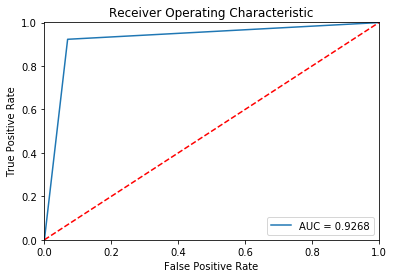

In [17]:
# plotting ROC curve
fpr, tpr, thresh= roc_curve(y_test, y_pred)

roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [18]:
optimal_proba_cutoff = sorted(list(zip(np.abs(prec - rec), thresh)), key=lambda i: i[0], reverse=False)[0][1]
roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in y_pred]

## After thresholding

In [19]:
print("Accuracy Score Before and After Thresholding: {}, {}".format(accuracy_score(y_test, y_pred), accuracy_score(y_test, roc_predictions)))
print("Precision Score Before and After Thresholding: {}, {}".format(precision_score(y_test, y_pred), precision_score(y_test, roc_predictions)))
print("Recall Score Before and After Thresholding: {}, {}".format(recall_score(y_test, y_pred), recall_score(y_test, roc_predictions)))
print("F1 Score Before and After Thresholding: {}, {}".format(f1_score(y_test, y_pred), f1_score(y_test, roc_predictions)))


Accuracy Score Before and After Thresholding: 0.926923076923077, 0.926923076923077
Precision Score Before and After Thresholding: 0.9267326732673268, 0.9267326732673268
Recall Score Before and After Thresholding: 0.9230769230769231, 0.9230769230769231
F1 Score Before and After Thresholding: 0.924901185770751, 0.924901185770751


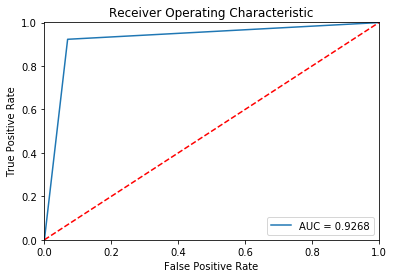

In [20]:
fpr, tpr, thresh= roc_curve(y_test, roc_predictions)

roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

The evaluation is exactly the same that means it is already working with highest possible recall and precison.
Let's try hyperparameters of the vectorizer and the classifer.

##  Hyperparameter tuning

In [22]:
# Creating a pipeline with inital classifier as PassiveAggressiveClassifier

text = Pipeline([
                ('tfidf', TfidfVectorizer( stop_words='english')),
                ('classifier', PassiveAggressiveClassifier())
            ])

In [26]:
# Assigning different parameters, along with multiple classifiers to search from

parameters = [{'tfidf__max_df': (0.5, 0.75, 1.0),
               'tfidf__max_features' : (None,2000,  5000),
               'tfidf__ngram_range': ((1,1),(1,2),(1,3)),
               'tfidf__norm': ('l1','l2',None)},
              {'classifier':[MultinomialNB()]},
             {'classifier':[LinearSVC()],
             'classifier__max_iter': [1000,2000,4000]},
             {'classifier':[PassiveAggressiveClassifier()],
             'classifier__C':[1, 10, 100, 1000],
             'classifier__max_iter':[1000,2000,4000]},
             {'classifier':[LogisticRegression()],
             'classifier__solver':['liblinear'],
             'classifier__max_iter':[1000,2000,4000]},
             {'classifier':[KNeighborsClassifier()]}]

In [27]:
# initializing the gridsearchCV

grid = GridSearchCV(text,parameters,refit = True, verbose=2)

In [28]:
# fitting the training data in the model
# or searching for best parameters 
best_model = grid.fit(x_train_text,y_train)

C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 101 candidates, totalling 303 fits
[CV] tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l1, total=  10.4s
[CV] tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.3s remaining:    0.0s
C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l1, total=  10.3s
[CV] tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l1, total=  10.3s
[CV] tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l2, total=   9.5s
[CV] tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l2, total=   9.5s
[CV] tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l2, total=   9.5s
[CV] tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=None, total=   9.6s
[CV] tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=None, total=   9.5s
[CV] tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=None, total=   9.6s
[CV] tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l1, total=  41.4s
[CV] tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l1, total=  41.1s
[CV] tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l1, total=  41.0s
[CV] tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l2, total=  30.8s
[CV] tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l2, total=  30.8s
[CV] tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l2, total=  30.7s
[CV] tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=None, total=  30.9s
[CV] tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=None, total=  31.3s
[CV] tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=None, total=  30.8s
[CV] tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l1, total= 1.3min
[CV] tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l1, total= 1.3min
[CV] tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l1, total= 1.3min
[CV] tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l2, total=  55.6s
[CV] tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l2, total=  55.7s
[CV] tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l2, total=  55.1s
[CV] tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=None, total=  55.6s
[CV] tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=None, total=  55.5s
[CV] tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=None, total=  55.7s
[CV] tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, total=   9.4s
[CV] tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, total=   9.4s
[CV] tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, total=   9.4s
[CV] tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l2, total=   9.3s
[CV] tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l2, total=   9.3s
[CV] tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l2, total=   9.3s
[CV] tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=None, total=   9.3s
[CV] tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=None, total=   9.4s
[CV] tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=None, total=   9.5s
[CV] tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l1, total=  26.6s
[CV] tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l1, total=  26.6s
[CV] tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l1, total=  26.6s
[CV] tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, total=  26.5s
[CV] tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, total=  26.6s
[CV] tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, total=  26.8s
[CV] tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=None, total=  26.6s
[CV] tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=None, total=  26.6s
[CV] tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=None, total=  26.6s
[CV] tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l1, total=  49.9s
[CV] tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l1, total=  49.8s
[CV] tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l1, total=  49.6s
[CV] tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l2, total=  49.8s
[CV] tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l2, total=  50.3s
[CV] tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l2, total=  49.4s
[CV] tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=None, total=  49.9s
[CV] tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=None, total=  49.8s
[CV] tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=None, total=  49.4s
[CV] tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, total=   9.7s
[CV] tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, total=   9.7s
[CV] tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, total=   9.7s
[CV] tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l2, total=   9.6s
[CV] tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l2, total=   9.3s
[CV] tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l2, total=   9.4s
[CV] tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None, total=   9.3s
[CV] tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None, total=  10.3s
[CV] tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None, total=  13.9s
[CV] tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l1, total=  34.1s
[CV] tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l1, total=  33.7s
[CV] tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l1, total=  33.2s
[CV] tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, total=  33.0s
[CV] tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, total=  33.2s
[CV] tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, total=  32.8s
[CV] tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=None, total=  32.3s
[CV] tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=None, total=  33.2s
[CV] tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=None, total=  33.1s
[CV] tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l1, total= 1.0min
[CV] tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l1, total= 1.0min
[CV] tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l1, total= 1.0min
[CV] tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l2, total=  50.3s
[CV] tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l2, total=  51.0s
[CV] tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l2, total=  49.4s
[CV] tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=None, total=  49.4s
[CV] tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=None, total=  50.0s
[CV] tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.5, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=None, total=  49.5s
[CV] tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l1, total=  10.4s
[CV] tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l1, total=  10.7s
[CV] tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l1, total=  10.4s
[CV] tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l2, total=   9.8s
[CV] tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l2, total=   9.6s
[CV] tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l2, total=   9.7s
[CV] tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=None, total=   9.6s
[CV] tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=None, total=   9.6s
[CV] tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=None, total=   9.7s
[CV] tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l1, total=  40.1s
[CV] tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l1, total=  39.9s
[CV] tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l1, total=  40.4s
[CV] tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l2, total=  31.0s
[CV] tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l2, total=  30.9s
[CV] tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l2, total=  31.0s
[CV] tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=None, total=  31.0s
[CV] tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=None, total=  31.0s
[CV] tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=None, total=  30.9s
[CV] tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l1, total= 1.3min
[CV] tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l1, total= 1.3min
[CV] tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l1, total= 1.5min
[CV] tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l2, total= 1.2min
[CV] tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l2, total= 1.2min
[CV] tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l2, total= 1.2min
[CV] tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=None, total= 1.2min
[CV] tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=None, total= 1.2min
[CV] tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=None, total= 1.1min
[CV] tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, total=  11.8s
[CV] tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, total=  11.8s
[CV] tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, total=  11.8s
[CV] tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l2, total=  11.6s
[CV] tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l2, total=  11.7s
[CV] tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l2, total=  11.6s
[CV] tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=None, total=  11.7s
[CV] tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=None, total=  11.7s
[CV] tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=None, total=  11.9s
[CV] tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l1, total=  33.5s
[CV] tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l1, total=  34.1s
[CV] tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l1, total=  33.0s
[CV] tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, total=  32.7s
[CV] tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, total=  28.3s
[CV] tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, total=  26.6s
[CV] tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=None, total=  27.0s
[CV] tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=None, total=  26.8s
[CV] tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=None, total=  26.7s
[CV] tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l1, total=  49.7s
[CV] tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l1, total=  50.0s
[CV] tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l1, total=  49.7s
[CV] tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l2, total=  49.7s
[CV] tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l2, total=  49.3s
[CV] tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l2, total=  48.7s
[CV] tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=None, total=  49.4s
[CV] tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=None, total=  49.3s
[CV] tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=None, total=  48.9s
[CV] tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, total=   9.6s
[CV] tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, total=   9.6s
[CV] tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, total=   9.6s
[CV] tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l2, total=   9.2s
[CV] tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l2, total=   9.2s
[CV] tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l2, total=   9.3s
[CV] tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None, total=   9.4s
[CV] tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None, total=   9.2s
[CV] tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None, total=   9.2s
[CV] tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l1, total=  28.1s
[CV] tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l1, total=  32.4s
[CV] tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l1, total=  33.2s
[CV] tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, total=  32.8s
[CV] tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, total=  33.0s
[CV] tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, total=  32.7s
[CV] tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=None, total=  41.8s
[CV] tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=None, total=  33.1s
[CV] tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=None, total=  32.8s
[CV] tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l1, total= 1.0min
[CV] tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l1, total= 1.0min
[CV] tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l1, total= 1.0min
[CV] tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l2, total= 1.0min
[CV] tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l2, total= 1.0min
[CV] tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l2, total= 1.0min
[CV] tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=None, total= 1.0min
[CV] tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=None, total= 1.0min
[CV] tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=0.75, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=None, total= 1.0min
[CV] tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l1, total=  13.0s
[CV] tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l1, total=  12.9s
[CV] tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l1, total=  12.9s
[CV] tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l2, total=  11.9s
[CV] tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l2, total=  11.9s
[CV] tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=l2, total=  11.9s
[CV] tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=None, total=  11.9s
[CV] tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=None, total=  11.9s
[CV] tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 1), tfidf__norm=None, total=  11.9s
[CV] tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l1, total=  50.7s
[CV] tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l1, total=  50.7s
[CV] tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l1, total=  46.8s
[CV] tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l2, total=  32.7s
[CV] tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l2, total=  33.9s
[CV] tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=l2, total=  38.6s
[CV] tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=None, total=  38.6s
[CV] tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=None, total=  38.5s
[CV] tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 2), tfidf__norm=None, total=  38.7s
[CV] tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l1, total= 1.6min
[CV] tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l1, total= 1.3min
[CV] tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l1, total= 1.3min
[CV] tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l2, total=  55.8s
[CV] tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l2, total=  56.4s
[CV] tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=l2, total=  55.4s
[CV] tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=None, total=  56.2s
[CV] tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=None, total=  56.1s
[CV] tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=None, tfidf__ngram_range=(1, 3), tfidf__norm=None, total=  55.6s
[CV] tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, total=   9.5s
[CV] tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, total=   9.4s
[CV] tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, total=   9.4s
[CV] tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l2, total=   9.3s
[CV] tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l2, total=   9.4s
[CV] tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=l2, total=   9.4s
[CV] tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=None, total=   9.4s
[CV] tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=None, total=   9.4s
[CV] tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__norm=None, total=   9.4s
[CV] tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l1, total=  26.8s
[CV] tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l1, total=  27.0s
[CV] tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l1, total=  26.6s
[CV] tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, total=  26.5s
[CV] tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, total=  26.7s
[CV] tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, total=  26.7s
[CV] tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=None, total=  26.9s
[CV] tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=None, total=  26.7s
[CV] tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__norm=None, total=  26.7s
[CV] tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l1, total=  49.8s
[CV] tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l1, total=  49.9s
[CV] tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l1, total=  49.7s
[CV] tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l2, total=  49.8s
[CV] tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l2, total=  49.8s
[CV] tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=l2, total=  49.7s
[CV] tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=None, total=  49.9s
[CV] tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=None, total=  50.2s
[CV] tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=2000, tfidf__ngram_range=(1, 3), tfidf__norm=None, total=  49.5s
[CV] tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, total=   9.7s
[CV] tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, total=   9.7s
[CV] tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, total=   9.7s
[CV] tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l2, total=   9.3s
[CV] tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l2, total=   9.3s
[CV] tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l2, total=   9.4s
[CV] tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None, total=   9.5s
[CV] tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None, total=   9.4s
[CV] tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None, total=   9.4s
[CV] tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l1, total=  27.0s
[CV] tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l1, total=  27.0s
[CV] tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l1, total=  26.9s
[CV] tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, total=  27.2s
[CV] tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, total=  26.6s
[CV] tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, total=  26.6s
[CV] tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=None, total=  26.8s
[CV] tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=None, total=  26.7s
[CV] tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=None, total=  26.8s
[CV] tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l1, total=  50.0s
[CV] tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l1, total=  50.3s
[CV] tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l1 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l1, total=  49.9s
[CV] tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l2, total=  49.6s
[CV] tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l2, total=  50.0s
[CV] tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l2 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=l2, total=  49.3s
[CV] tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=None, total=  49.8s
[CV] tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=None, total=  49.8s
[CV] tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=None 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  tfidf__max_df=1.0, tfidf__max_features=5000, tfidf__ngram_range=(1, 3), tfidf__norm=None, total=  49.9s
[CV] classifier=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), total=   9.7s
[CV] classifier=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), total=   9.5s
[CV] classifier=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), total=   9.5s
[CV] classifier=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0), classifier__max_iter=1000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0), classifier__max_iter=1000, total=   9.7s
[CV] classifier=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0), classifier__max_iter=1000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0), classifier__max_iter=1000, total=   9.7s
[CV] classifier=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0), classifier__max_iter=1000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0), classifier__max_iter=1000, total=   9.6s
[CV] classifier=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0), classifier__max_iter=2000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0), classifier__max_iter=2000, total=   9.7s
[CV] classifier=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=2000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0), classifier__max_iter=2000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=2000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0), classifier__max_iter=2000, total=   9.7s
[CV] classifier=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=2000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0), classifier__max_iter=2000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=2000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0), classifier__max_iter=2000, total=   9.7s
[CV] classifier=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=2000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0), classifier__max_iter=4000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=2000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0), classifier__max_iter=4000, total=   9.7s
[CV] classifier=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=4000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0), classifier__max_iter=4000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=4000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0), classifier__max_iter=4000, total=   9.7s
[CV] classifier=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=4000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0), classifier__max_iter=4000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=4000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0), classifier__max_iter=4000, total=   9.7s
[CV] classifier=PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1, classifier__max_iter=1000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1, classifier__max_iter=1000, total=   9.8s
[CV] classifier=PassiveAggressiveClassifier(C=1, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1, classifier__max_iter=1000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=1, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1, classifier__max_iter=1000, total=   9.6s
[CV] classifier=PassiveAggressiveClassifier(C=1, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1, classifier__max_iter=1000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=1, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1, classifier__max_iter=1000, total=   9.6s
[CV] classifier=PassiveAggressiveClassifier(C=1, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1, classifier__max_iter=2000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=1, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1, classifier__max_iter=2000, total=   9.6s
[CV] classifier=PassiveAggressiveClassifier(C=1, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=2000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1, classifier__max_iter=2000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=1, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=2000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1, classifier__max_iter=2000, total=   9.6s
[CV] classifier=PassiveAggressiveClassifier(C=1, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=2000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1, classifier__max_iter=2000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=1, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=2000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1, classifier__max_iter=2000, total=   9.6s
[CV] classifier=PassiveAggressiveClassifier(C=1, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=2000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1, classifier__max_iter=4000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=1, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=2000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1, classifier__max_iter=4000, total=   9.6s
[CV] classifier=PassiveAggressiveClassifier(C=1, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=4000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1, classifier__max_iter=4000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=1, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=4000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1, classifier__max_iter=4000, total=   9.6s
[CV] classifier=PassiveAggressiveClassifier(C=1, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=4000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1, classifier__max_iter=4000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=1, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=4000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1, classifier__max_iter=4000, total=   9.6s
[CV] classifier=PassiveAggressiveClassifier(C=1, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=4000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=10, classifier__max_iter=1000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=1, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=4000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=10, classifier__max_iter=1000, total=   9.6s
[CV] classifier=PassiveAggressiveClassifier(C=10, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=10, classifier__max_iter=1000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=10, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=10, classifier__max_iter=1000, total=   9.6s
[CV] classifier=PassiveAggressiveClassifier(C=10, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=10, classifier__max_iter=1000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=10, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=10, classifier__max_iter=1000, total=   9.6s
[CV] classifier=PassiveAggressiveClassifier(C=10, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=10, classifier__max_iter=2000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=10, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=10, classifier__max_iter=2000, total=   9.8s
[CV] classifier=PassiveAggressiveClassifier(C=10, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=2000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=10, classifier__max_iter=2000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=10, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=2000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=10, classifier__max_iter=2000, total=   9.7s
[CV] classifier=PassiveAggressiveClassifier(C=10, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=2000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=10, classifier__max_iter=2000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=10, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=2000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=10, classifier__max_iter=2000, total=   9.6s
[CV] classifier=PassiveAggressiveClassifier(C=10, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=2000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=10, classifier__max_iter=4000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=10, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=2000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=10, classifier__max_iter=4000, total=   9.6s
[CV] classifier=PassiveAggressiveClassifier(C=10, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=4000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=10, classifier__max_iter=4000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=10, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=4000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=10, classifier__max_iter=4000, total=   9.6s
[CV] classifier=PassiveAggressiveClassifier(C=10, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=4000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=10, classifier__max_iter=4000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=10, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=4000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=10, classifier__max_iter=4000, total=   9.7s
[CV] classifier=PassiveAggressiveClassifier(C=10, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=4000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=100, classifier__max_iter=1000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=10, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=4000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=100, classifier__max_iter=1000, total=   9.6s
[CV] classifier=PassiveAggressiveClassifier(C=100, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=100, classifier__max_iter=1000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=100, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=100, classifier__max_iter=1000, total=   9.6s
[CV] classifier=PassiveAggressiveClassifier(C=100, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=100, classifier__max_iter=1000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=100, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=100, classifier__max_iter=1000, total=   9.6s
[CV] classifier=PassiveAggressiveClassifier(C=100, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=100, classifier__max_iter=2000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=100, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=100, classifier__max_iter=2000, total=   9.6s
[CV] classifier=PassiveAggressiveClassifier(C=100, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=2000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=100, classifier__max_iter=2000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=100, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=2000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=100, classifier__max_iter=2000, total=   9.7s
[CV] classifier=PassiveAggressiveClassifier(C=100, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=2000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=100, classifier__max_iter=2000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=100, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=2000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=100, classifier__max_iter=2000, total=   9.6s
[CV] classifier=PassiveAggressiveClassifier(C=100, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=2000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=100, classifier__max_iter=4000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=100, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=2000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=100, classifier__max_iter=4000, total=   9.6s
[CV] classifier=PassiveAggressiveClassifier(C=100, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=4000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=100, classifier__max_iter=4000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=100, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=4000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=100, classifier__max_iter=4000, total=   9.7s
[CV] classifier=PassiveAggressiveClassifier(C=100, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=4000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=100, classifier__max_iter=4000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=100, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=4000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=100, classifier__max_iter=4000, total=   9.7s
[CV] classifier=PassiveAggressiveClassifier(C=100, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=4000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1000, classifier__max_iter=1000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=100, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=4000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1000, classifier__max_iter=1000, total=   9.6s
[CV] classifier=PassiveAggressiveClassifier(C=1000, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1000, classifier__max_iter=1000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=1000, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1000, classifier__max_iter=1000, total=   9.7s
[CV] classifier=PassiveAggressiveClassifier(C=1000, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1000, classifier__max_iter=1000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=1000, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1000, classifier__max_iter=1000, total=   9.6s
[CV] classifier=PassiveAggressiveClassifier(C=1000, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1000, classifier__max_iter=2000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=1000, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1000, classifier__max_iter=2000, total=   9.6s
[CV] classifier=PassiveAggressiveClassifier(C=1000, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=2000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1000, classifier__max_iter=2000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=1000, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=2000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1000, classifier__max_iter=2000, total=   9.6s
[CV] classifier=PassiveAggressiveClassifier(C=1000, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=2000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1000, classifier__max_iter=2000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=1000, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=2000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1000, classifier__max_iter=2000, total=   9.6s
[CV] classifier=PassiveAggressiveClassifier(C=1000, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=2000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1000, classifier__max_iter=4000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=1000, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=2000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1000, classifier__max_iter=4000, total=   9.6s
[CV] classifier=PassiveAggressiveClassifier(C=1000, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=4000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1000, classifier__max_iter=4000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=1000, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=4000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1000, classifier__max_iter=4000, total=   9.7s
[CV] classifier=PassiveAggressiveClassifier(C=1000, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=4000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1000, classifier__max_iter=4000 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=PassiveAggressiveClassifier(C=1000, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=4000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False), classifier__C=1000, classifier__max_iter=4000, total=   9.7s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), classifier__max_iter=1000, classifier__solver=liblinear 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), classifier__max_iter=1000, classifier__solver=liblinear, total=  10.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), classifier__max_iter=1000, classifier__solver=liblinear 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), classifier__max_iter=1000, classifier__solver=liblinear, total=  10.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), classifier__max_iter=1000, classifier__solver=liblinear 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), classifier__max_iter=1000, classifier__solver=liblinear, total=  10.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), classifier__max_iter=2000, classifier__solver=liblinear 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), classifier__max_iter=2000, classifier__solver=liblinear, total=  10.0s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), classifier__max_iter=2000, classifier__solver=liblinear 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), classifier__max_iter=2000, classifier__solver=liblinear, total=  10.0s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), classifier__max_iter=2000, classifier__solver=liblinear 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), classifier__max_iter=2000, classifier__solver=liblinear, total=  10.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), classifier__max_iter=4000, classifier__solver=liblinear 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), classifier__max_iter=4000, classifier__solver=liblinear, total=  10.0s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=4000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), classifier__max_iter=4000, classifier__solver=liblinear 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=4000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), classifier__max_iter=4000, classifier__solver=liblinear, total=  10.0s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=4000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), classifier__max_iter=4000, classifier__solver=liblinear 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=4000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), classifier__max_iter=4000, classifier__solver=liblinear, total=  10.1s
[CV] classifier=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform') 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  classifier=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform'), total=  15.7s
[CV] classifier=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform') 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  classifier=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform'), total=  15.4s
[CV] classifier=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform') 


C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  classifier=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform'), total=  15.7s


[Parallel(n_jobs=1)]: Done 303 out of 303 | elapsed: 145.4min finished
C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [53]:
# The best parameters for our model are as follows
best_model.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.75, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pat...u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 PassiveAggressiveClassifier(C=1.0, average=False,
                                             class_weight=None,
        

In [48]:
# performing predictions on test data set and checking accuracy
pred_HT = best_model.predict(x_test_text)

score = accuracy_score(y_test,pred_HT)
print('Accuracy before thresholding is : {}'.format(round(score*100,2)))

Accuracy before thresholding is : 96.71


In [49]:
#Build confusion matrix
confusion_matrix(y_test,pred_HT, labels=[1,0])

array([[1931,   97],
       [  40, 2092]], dtype=int64)

In [50]:
print("Accuracy Score Before and After Hyperparameter Tuning: {}, {}".format(accuracy_score(y_test, pred_HT), accuracy_score(y_test, roc_predictions)))
print("Precision Score Before and After Hyperparameter Tuning: {}, {}".format(precision_score(y_test, pred_HT), precision_score(y_test, roc_predictions)))
print("Recall Score Before and After Hyperparameter Tuning: {}, {}".format(recall_score(y_test, pred_HT), recall_score(y_test, roc_predictions)))
print("F1 Score Before and After Hyperparameter Tuning: {}, {}".format(f1_score(y_test, pred_HT), f1_score(y_test, roc_predictions)))


Accuracy Score Before and After Hyperparameter Tuning: 0.9670673076923076, 0.926923076923077
Precision Score Before and After Hyperparameter Tuning: 0.9797057331303907, 0.9267326732673268
Recall Score Before and After Hyperparameter Tuning: 0.9521696252465484, 0.9230769230769231
F1 Score Before and After Hyperparameter Tuning: 0.9657414353588397, 0.924901185770751


It can be noticed that the precision before hyperparameter tuning is improved and other evaluation metrics have also improved

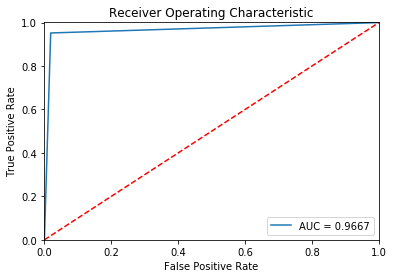

In [51]:
fpr, tpr, thresh= roc_curve(y_test, pred_HT)

roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

96.67% of the total area is covered under the curve which is better than the previous ~92% area covered.

## Training the model with the whole data 

In [71]:
Final_model = Pipeline([(
    'tfid', TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
    ('classifier',PassiveAggressiveClassifier(C=1.0, average=False,
                                             class_weight=None,
                                             early_stopping=False,
                                             fit_intercept=True, loss='hinge',
                                             max_iter=1000, n_iter_no_change=5,
                                             n_jobs=None, random_state=None,
                                             shuffle=True, tol=0.001,
                                             validation_fraction=0.1, verbose=0,
                                             warm_start=False))
    
])

In [76]:
# creatinf a final dataset for training the final model
x_final = news_copy['text'].copy()

# checking their shape
print(x_final.shape)
print(labels.shape)

(20800,)
(20800, 1)


In [77]:
# Training the final model
Final_model.fit(x_final,labels)

C:\Users\ysanj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('tfid',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern...u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 PassiveAggressiveClassifier(C=1.0, average=False,
                                             class_weight=None,
        

In [78]:
# saving the model 
import pickle
filename = "fake_detect_model.pkl"
with open(filename,'wb') as file:
    pickle.dump(Final_model, file)

In [85]:
'''
# # # Retrieving the model
#Load from file

with open(filename, 'rb') as file:
    pickle_model = pickle.load(file)
    
# Calculate the accuracy score and predict target values
score = pickle_model.score(x_test_text, y_test)
print("Test score: {0:.2f} %".format(100 * score))

'''


'\n# # # Retrieving the model\n#Load from file\n\nwith open(filename, \'rb\') as file:\n    pickle_model = pickle.load(file)\n    \n# Calculate the accuracy score and predict target values\nscore = pickle_model.score(x_test_text, y_test)\nprint("Test score: {0:.2f} %".format(100 * score))\n\n'